## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

## Preparación de Datos para Regresión

In [2]:
# Leer el CSV
data = pd.read_csv('../../data/EstudioCrediticio_TrainP.csv')

# Eliminar la primera columna
data = data.iloc[:, 1:]
# Eliminar la penúltima columna
data = data.iloc[:, :-2].join(data.iloc[:, -1])
# Eliminar las columnas con correlación alta (más de 0.9)
data = data.drop(['IngresoBrutoAnual', 'Experiencia', 'TotalActivos'], axis=1)

# Separar las características (X) y la variable a predecir (y)
X = data.iloc[:, :-1]  # Todas las columnas menos la última
y = data.iloc[:, -1]   # La última columna

# Identificar columnas numéricas y categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

### Creación de Pipelines

Se crearán las siguientes Pipelines para el preprocesado de los datos:
- En las variables categóricas, se aplicará un imputado basado en la moda y un OneHotEncoder para conseguir arrays numéricos
- En las variables numéricas, se aplicará un imputado basado en la media y se escalarán las variables con PowerTransformer, que aplica una transformación de potencia para hacer que los datos sean más gaussianos, reduciendo el impacto de los outliers. Se usará el método yeo-johnson al tener valores positivos y negativos.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

En segundo lugar, nos preguntamos: ¿Cuál es el **mejor modelo de regresión Lineal**?

Se usará una Pipeline final que une el **preprocesamiento** de datos con el **regresor**, y posteriormente se realizará **validación cruzada** para comprobar que modelo de regresión lineal da mejor rendimiento. Se probará con _LinearRegression()_, _Ridge()_ que incluye penalización L2, _Lasso()_ que incluye regularización L1, y _ElasticNet()_ que utiliza ambas penalizaciones.

In [4]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]

for regressor in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
    ])

    # Definir la estrategia de validación cruzada con KFold
    kfold = KFold(n_splits=10, shuffle=True, random_state=73)

    # Usar cross_val_score para evaluar el modelo utilizando KFold
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['regressor']}: {results.mean()}')

Accuracy promedio LinearRegression(): 0.7628997824842334
Accuracy promedio Ridge(): 0.7629229366104635
Accuracy promedio Lasso(): 0.6182332965886205
Accuracy promedio ElasticNet(): 0.6051881813789377


Se observa que tanto la Regresión Lineal como Ridge ofrecen un rendimiento similar y funcionan mejor en nuestro conjunto de datos. No obstante, los resultados obtenidos no son satisfactorios.

### Evaluación del modelo mediante train, test y métricas

También queremos obtener métricas como la raíz del error cuadrático medio o el error absoluto medio además del R^2 score.

Para ello, dividimos el conjunto de datos en train y test, entranamos y evaluamos.

Usaremos en este caso la Regresión Lineal:

In [5]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
       'TipoInteresBase', 'TipoInteres', 'PagoMensualCredito',
       'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [6]:
y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 3.870826795435466
MAE: 3.2124556616210933
R²: 0.7610885897526452


### Regresión Polinómica

In [ ]:
class PearsonCorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.to_drop_ = self._get_correlated_features(X)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        return X.drop(columns=self.to_drop_, errors='ignore')

    def _get_correlated_features(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return to_drop

In [ ]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# X_enc = preprocessor.fit_transform(X)

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('polfeatures', PolynomialFeatures(degree=2)),
    ('pearson_filter', PearsonCorrelationFilter(threshold=0.9)),
    ('regressor', LinearRegression())
    ])

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('polfeatures', PolynomialFeatures()),
                ('pearson_filter', PearsonCorrelationFilter()),
                ('regressor', LinearRegression())])

In [ ]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Coeficiente de determinación (R^2): {r2}')

Coeficiente de determinación (R^2): 0.8500930061326782


## Ensemble: Random Forest Regressor

Se desarrollarán las pipelines utilizando el mismo enfoque que en el modelo anterior. Sin embargo, a diferencia de este, el PowerTransformer() u otro escalador no son necesarios, ya que los árboles de decisión no se ven influenciados por la escala de las variables.

In [7]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=73))
])

Se realizará un Randomized Search para encontrar los **mejores hiperparámetros** para nuestro RandomForest.

En este caso, la búsqueda será muy lenta, y el hiperparámetro que nos interesa conocer el número de estimadores (árboles de decisión) que utilizará el random forest.

**GridSearch VS Randomized Search**: 
La diferencia radice en el tiempo de ejecución. Para el mismo espacio de parámetros, el RandomizedSearch selecciona un conjunto de combinaciones al azar a partir del espacio de búsqueda que defines, reduciendo drásticamente el tiempo necesario a cambio de un rendimiento similar o levemente peor. Además, ambos utilizan por defecto **validación cruzada** de 5 folds.

In [6]:
# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores parámetros:", random_search.best_params_)

c:\Users\guigr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros: {'regressor__n_estimators': 500}


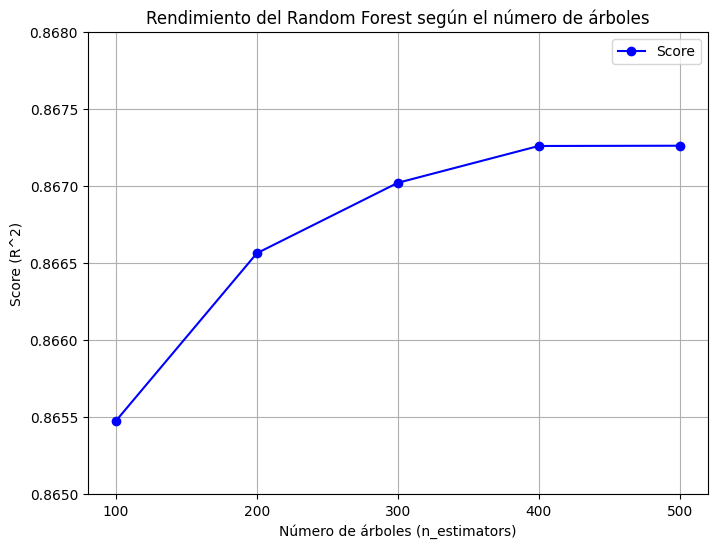

In [17]:
scores = random_search.cv_results_['mean_test_score']
params = [100, 200, 300, 400, 500]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(params, scores, marker='o', linestyle='-', color='b', label='Score')
plt.title('Rendimiento del Random Forest según el número de árboles')
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Score (R^2)')
plt.grid(True)
plt.xticks(params)
plt.ylim(0.865, 0.868)
plt.legend()

Podemos comprobar que el error se estabiliza entorno a los 300 estimadores. En otras palabras, con un número mayor de estimadores no se obtienen mejores resultados.

Por ello, entrenaremos un modelo con dichos hiperparámetros y observaremos su rendimiento en test de la misma forma que en el modelo anterior.

In [8]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=73, n_estimators=300))
])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito', 'RatioDeudaIngresos',
       'Histori...
       'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(n_estimators=300, random_state=73))])

In [9]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de train: {train_score:.4f}")
print(f"R² del conjunto de test: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE de test: {rmse}")
print(f"MAE de test: {mae}")

R² del conjunto de train: 0.9824
R² del conjunto de test: 0.8676
RMSE de test: 2.8810710948148746
MAE de test: 1.7357042


## Ensemble: Boosting

Para comenzar, probaremos a simple vista qué modelo funciona mejor entre AdaBoostRegressor, GrandientBoostingRegressor y HistGradientBoostingRegressor.

In [32]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [11]:
models = [AdaBoostRegressor(), GradientBoostingRegressor(), HistGradientBoostingRegressor()]

for regressor in models:
    # Crear pipeline final con preprocesamiento y modelo
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
    ])

    # Definir la estrategia de validación cruzada con KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=73)

    # Usar cross_val_score para evaluar el modelo utilizando KFold
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    # Mostrar los resultados
    print(f'Accuracy promedio {model.named_steps['regressor']}: {results.mean()}')

Accuracy promedio AdaBoostRegressor(): 0.6227754501866463
Accuracy promedio GradientBoostingRegressor(): 0.866901944634825
Accuracy promedio HistGradientBoostingRegressor(): 0.895683426210711


Se puede observar que el _HistGradientBoostingRegressor()_ obtiene el mejor rendimiento. Además, este estimador tiene **soporte nativo para valores faltantes** (NaN), por lo que no sería necesario aplicar los imputadores en las Pipelines, y es mucho **más rápido** en conjuntos grandes de datos como el nuestro.

Veamos si el uso de los imputadores empeoraba o no el resultado:

In [33]:
# Pipeline para variables categóricas
categorical_transformer_no_imputer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline para variables numéricas
numeric_transformer_no_imputer = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor_no_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_no_imputer, numeric_cols),
        ('cat', categorical_transformer_no_imputer, categorical_cols)
    ])

# Modelo
model_no_imputer = Pipeline(steps=[
    ('preprocessor', preprocessor_no_imputer),
    ('regressor', HistGradientBoostingRegressor())
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=73)
results = cross_val_score(model_no_imputer, X_train, y_train, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

R^2 promedio: 0.8962608529223239


Se comprueba que el uso de los imputadores da el mismo resultado.

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**.

In [34]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor_no_imputer),
    ('regressor', HistGradientBoostingRegressor())
    ])

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'regressor__loss': ['squared_error', 'absolute_error', 'poisson'],
    'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'regressor__max_iter': [100, 200, 300, 400, 500],
    'regressor__max_depth': [5, 10, 15, 20],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor puntaje de validación cruzada: 0.899652411589714
Mejores parámetros: {'regressor__max_iter': 200, 'regressor__max_depth': 15, 'regressor__loss': 'poisson', 'regressor__learning_rate': 0.1}


In [39]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor_no_imputer),
    ('regressor', HistGradientBoostingRegressor(max_depth=15, learning_rate=0.1, loss='poisson', max_iter=200))
    ])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito', 'RatioDeudaIngresos',
       'Histo...
       'TipoInteresBase', 'TipoInteres', 'PagoMensualCredito',
       'RatioTotalDeudaIngresos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 HistGradientBoostingRegressor(loss='poisson', max_depth=15,
                                               max_iter=200))])

In [40]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9320
R² del conjunto de prueba: 0.8993
RMSE: 2.513065877829
MAE: 1.6763178529437532


De manera adicional, nos gustaría probar el **Extreme Gradient Boosting**. 

XGBoost es una biblioteca separada de sklearn muy optimizada para _Gradient Boosting_, diseñada para ser altamente eficiente, flexible y portátil. Esto se debe a la utilización de métodos como el aprendizaje en paralelo o parámetros de regularización.

Ahora haremos un RandomizedSearch con sus numerosos parámetros. En total esta búsqueda contendría 3125 combinaciones, que sumado a la validación cruzada, en total se realizarían 15625 fits. Gracias al RandomizedSearch podemos acotar las iteraciones a 100 aleatorias, realizando 500 fits, que junto a la eficiencia del XGBoost resultará en un tiempo menor.

In [23]:
# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', xgb.XGBRegressor(tree_method="hist", random_state=73))
])

param_dist = {
    'regressor__n_estimators': [100, 200, 300, 500, 1000],  # Número de árboles
    'regressor__max_depth': [3, 5, 7, 9, 10],               # Profundidad máxima de los árboles
    'regressor__eta': [0.01, 0.05, 0.1, 0.2, 0.3],          # Tasa de aprendizaje (learning rate)
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Fracción de muestras utilizadas en cada árbol
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Fracción de columnas utilizadas en cada árbol
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    n_iter=100,                                # Número de combinaciones aleatorias a probar
    verbose=1,                                # Mostrar progreso en la consola
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejor puntaje de validación cruzada: 0.9036563817490212
Mejores parámetros: {'regressor__subsample': 0.7, 'regressor__n_estimators': 500, 'regressor__max_depth': 7, 'regressor__eta': 0.05, 'regressor__colsample_bytree': 0.9}


In [17]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(tree_method="hist", random_state=73, subsample=0.7, n_estimators=500, max_depth=7, eta=0.05, colsample_bytree=0.9))
    ])

# Ajustar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [19]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9643
R² del conjunto de prueba: 0.9039
RMSE: 2.454827714048063
MAE: 1.587651873664856


No se ha encontrado una mejora muy significativa.

## MLP Regressor

Por último, probaremos con una red neuronal MLPRegressor (perceptrón multicapa). En ella, es necesario normalizar e imputar los valores faltantes.

In [27]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

De nuevo, realizaremos un RandomizedSearch para obtener los mejores **hiperparámetros**.

En este caso, usaremos **early stopping** en el MLP con un máximo de iteraciones de 1000. Gracias al early stopping, el RandomizedSearch se realizará en un tiempo mucho menor.

In [28]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor())
    ])

# Configurar RandomizedSearchCV
param_dist = {
    'regressor__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'regressor__activation': ['tanh', 'relu'],
    'regressor__solver': ['adam', 'sgd'],
    'regressor__max_iter': [1000],
    'regressor__early_stopping': [True],
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,                                    # Pipeline
    param_distributions=param_dist,           # Hiperparámetros (espacio de búsqueda)
    verbose=1,                                # Mostrar progreso en la consola
    n_jobs=-1,                                # Usar todos los núcleos disponibles
    random_state=73                           # Reproducibilidad
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejor puntaje de validación cruzada:", random_search.best_score_)
print("Mejores parámetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor puntaje de validación cruzada: 0.917284877357212
Mejores parámetros: {'regressor__solver': 'sgd', 'regressor__max_iter': 1000, 'regressor__hidden_layer_sizes': (64,), 'regressor__early_stopping': True, 'regressor__activation': 'tanh'}


Podemos comprobar que se obtiene un R^2 score de casi 0.92 con los mejores hiperparámetros.

In [29]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True))
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 MLPRegressor(activation='tanh', early_stopping=True,
                              hidden_layer_sizes=(64,), max_iter=1000,
                              solver='sgd'))])

In [30]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9277
R² del conjunto de prueba: 0.9175
RMSE: 2.275213676151055
MAE: 1.5003742206956177


## Ensemble: Voting Regressor

Para terminar, usaremos un modelo _VotingRegressor()_ con los tres mejores modelos obtenidos, dando como resultado el promedio de las predicciones individuales de cada modelo para formar una predicción final. ¿Podría ocurrir que el Boosting ayude en algunos casos?

In [8]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Se incluyen ahora los tres mejores regresores obtenidos hasta ahora:
- MLPRegressor
- XGBRegressor
- HistGradientBoostingRegressor

In [4]:
regressor1 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor2 = xgb.XGBRegressor(tree_method="hist", random_state=73, subsample=0.7, n_estimators=500, max_depth=5, eta=0.05, colsample_bytree=0.8)
regressor3 = HistGradientBoostingRegressor(max_depth=15, learning_rate=0.1, loss='poisson', max_iter=200)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor([('mlp', regressor1), ('xgb', regressor2), ('hgb', regressor3)]))
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=73)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

R^2 promedio: 0.9198916436200054


In [9]:
regressor1 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor2 = xgb.XGBRegressor(tree_method="hist", random_state=73, subsample=0.7, n_estimators=500, max_depth=5, eta=0.05, colsample_bytree=0.8)
regressor3 = HistGradientBoostingRegressor(max_depth=15, learning_rate=0.1, loss='poisson', max_iter=200)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor([('mlp', regressor1), ('xgb', regressor2), ('hgb', regressor3)]))
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=500,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...)),
                                             ('hgb',
                                              HistGradientBoostingRegressor(loss='poisson',
                                                                            max_depth=15,
                                                                            max_iter=200))]))])

In [10]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9384
R² del conjunto de prueba: 0.9173
RMSE: 2.277427543664389
MAE: 1.4730628971646536


El resultado es similar al obtenido utilizando únicamente el MLP.

También haremos una última prueba usando 10 MLPs. En otras palabras, vamos a probar 10 instancias del modelo que mejores resultados ha devuelto para observar si el promedio de sus decisiones nos da mejores resultados. De esta manera, reducimos su variabilidad al disminuir el efecto de la aleatoriedad de las MLPs.

In [11]:
regressor1 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor2 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor3 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor4 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor5 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor6 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor7 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor8 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor9 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor10 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor([('mlp1', regressor1),('mlp2', regressor2),('mlp3', regressor3), ('mlp4', regressor4),('mlp5', regressor5),('mlp6', regressor6),('mlp7', regressor7),('mlp8', regressor8),('mlp9', regressor9),('mlp10', regressor10)]))
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=73)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

R^2 promedio: 0.9210684525335268


In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor([('mlp1', regressor1),('mlp2', regressor2),('mlp3', regressor3), ('mlp4', regressor4),('mlp5', regressor5),('mlp6', regressor6),('mlp7', regressor7),('mlp8', regressor8),('mlp9', regressor9),('mlp10', regressor10)]))
    ])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                           solver='sgd')),
                                             ('mlp8',
                                              MLPRegressor(activation='tanh',
                                                           early_stopping=True,
                                                           hidden_layer_sizes=(64,),
                                                           max_iter=1000,
                                                           solver='sgd')),
                                             ('mlp9',
                                              MLPRegressor(activation='tanh',
                                                           early_stopping=True,
                                                           hidden_layer_sizes=(64,),
                                                           max_iter=1000,
                                                           solver='sgd')),
                                             ('mlp10',
                                              MLPRegressor(activation='tanh',
                                                           early_stopping=True,
                                                           hidden_layer_sizes=(64,),
                                                           max_iter=1000,
                                                           solver='sgd'))]))])

In [13]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9309
R² del conjunto de prueba: 0.9215
RMSE: 2.218880467373268
MAE: 1.423668706546837


La mejora ha sido muy leve con este _VotingRegressor()_ a costa de emplear muchos más recursos y tiempo.

## Ensemble: Bagging

Visto lo visto, combinar varios MLP puede ser productivo. Al usar el mismo modelo en todas las instancias, es más típico utilizar _BaggingRegressor()_, que también devolverá la media de las predicciones, aunque incluye algunas técnicas durante el entrenamiento como el bootstrapping.

Es por ello que haremos una prueba final con un **Bagging** de **25 regresores MLP**.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [5]:
regression = MLPRegressor(solver='adam', hidden_layer_sizes=(64,32), activation='tanh', max_iter=1000, early_stopping=True)

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', BaggingRegressor(estimator=regression, n_estimators=25, random_state=42, n_jobs=-1))
])

In [6]:
# Entrenar
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 BaggingRegressor(estimator=MLPRegressor(activation='tanh',
                                                         early_stopping=True,
                                                         hidden_layer_sizes=(64,
                                                                             32),
                                                         max_iter=1000),
                                  n_estimators=25, n_jobs=-1,
                                  random_state=42))])

In [7]:
# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"R² del conjunto de entrenamiento: {train_score:.4f}")
print(f"R² del conjunto de prueba: {test_score:.4f}")

y_pred = model.predict(X_test)

# Calcular métricas para regresión
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R² del conjunto de entrenamiento: 0.9601
R² del conjunto de prueba: 0.9262
RMSE: 2.150671180660725
MAE: 1.2622474581842567


Observamos que el tiempo necesario es alto, aunque se puede reducir incluyendo _n-jobs = -1_ para usar todos los procesadores. No obstante, el **resultado** es el **mejor** hasta ahora, superando el R^2 score de 0.925.

## Competición

El modelo elegido fue el _VotingRegressor()_ que utiliza 10 MLPs al presentar las mejores métricas, a pesar de ser pesado computacionalmente.

Para la competición, se ha decidido entrenar los modelos con todo el conjunto de datos (50.000 datos). 

Utilizaremos validación cruzada con 10 folds para estimar el error.

In [3]:
# Pipeline para variables categóricas (Imputación + OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Pipeline para variables numéricas (Imputación + Escalado)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar con la media
    ('scaler', PowerTransformer(method='yeo-johnson')), # Escalar debido a outliers
])

# Combinación de transformaciones para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [31]:
regressor1 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor2 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor3 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor4 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor5 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor6 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor7 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor8 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor9 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)
regressor10 = MLPRegressor(solver='sgd', hidden_layer_sizes=(64,), activation='tanh', max_iter=1000, early_stopping=True)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor([('mlp1', regressor1),('mlp2', regressor2),('mlp3', regressor3), ('mlp4', regressor4),('mlp5', regressor5),('mlp6', regressor6),('mlp7', regressor7),('mlp8', regressor8),('mlp9', regressor9),('mlp10', regressor10)]))
    ])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=73)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(f'R^2 promedio: {results.mean()}')

R^2 promedio: 0.924010070902286


In [7]:
regression = MLPRegressor(solver='adam', hidden_layer_sizes=(64,32), activation='tanh', max_iter=1000, early_stopping=True)

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', BaggingRegressor(estimator=regression, n_estimators=25, random_state=42, n_jobs=-1))
])

# Usar cross_val_score para evaluar el modelo utilizando KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=73)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2', n_jobs=-1)
print(f'R^2 promedio: {results.mean()}')

R^2 promedio: 0.9270970809960595


Guardamos el modelo para la competición

In [4]:
regression = MLPRegressor(solver='adam', hidden_layer_sizes=(64,32), activation='tanh', max_iter=1000, early_stopping=True)

# Crear pipeline final con preprocesamiento y modelo
model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', BaggingRegressor(estimator=regression, n_estimators=25, random_state=42, n_jobs=-1))
])

# Entrenar
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  Index(['Edad', 'ScoreCrediticio', 'CuantiaCredito', 'DuracionCredito',
       'NumeroPersonasDependientes', 'PagoMensualDeuda',
       'TasaUtilizacionTarjetaCredito', 'NumeroLineasCreditoAbiertas',
       'NumeroSolicitudesCredito'...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SituacionLaboral', 'NivelEducativo', 'EstadoCivil', 'EstadoVivienda',
       'ObjetoCredito'],
      dtype='object'))])),
                ('regressor',
                 BaggingRegressor(estimator=MLPRegressor(activation='tanh',
                                                         early_stopping=True,
                                                         hidden_layer_sizes=(64,
                                                                             32),
                                                         max_iter=1000),
                                  n_estimators=25, n_jobs=-1,
                                  random_state=42))])

In [6]:
import joblib

# Guardar el modelo
joblib.dump(model, '../../model/model_regression.pkl')

['../../model/model_regression.pkl']

## Conclusiones

Se mostrarán gráficos de cómo ha ido mejorando el rendimiento a lo largo de las pruebas en diferentes modelos de regresión.

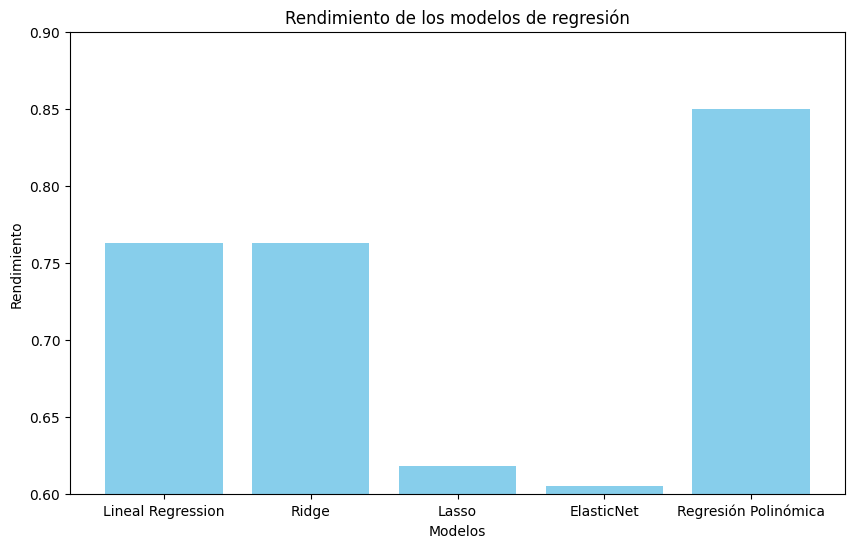

In [16]:
#  En cuanto a los numerosos modelos de Regresión Lineal
# Lista de resultados de los modelos (rendimientos)
resultados = [0.7629,0.7629,0.6182,0.6051,0.85]  # ejemplo de rendimientos

# Lista de nombres de los modelos
nombres_modelos = ["Lineal Regression", "Ridge", "Lasso", "ElasticNet", "Regresión Polinómica"]

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))
plt.ylim(0.6, 0.9)  # Limitar el rango del eje Y para que no se escale automáticamente

# Dibujar el histograma con los modelos acumulados
plt.bar(nombres_modelos[:], resultados[:], color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Rendimiento')
plt.title('Rendimiento de los modelos de regresión')

# Mostrar el gráfico
plt.show()


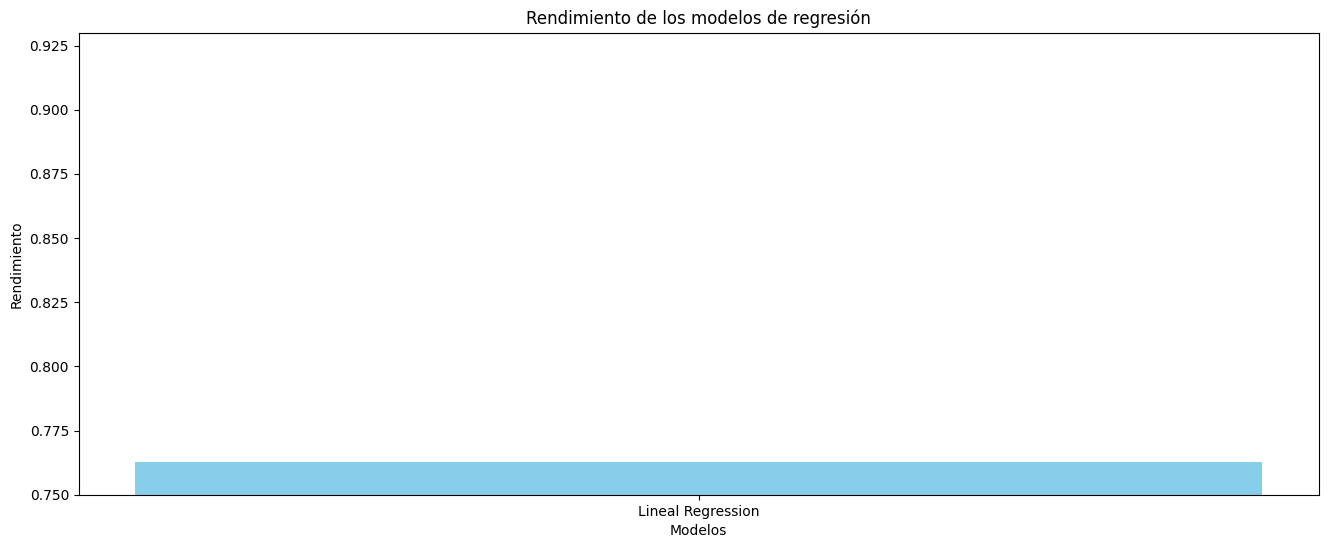

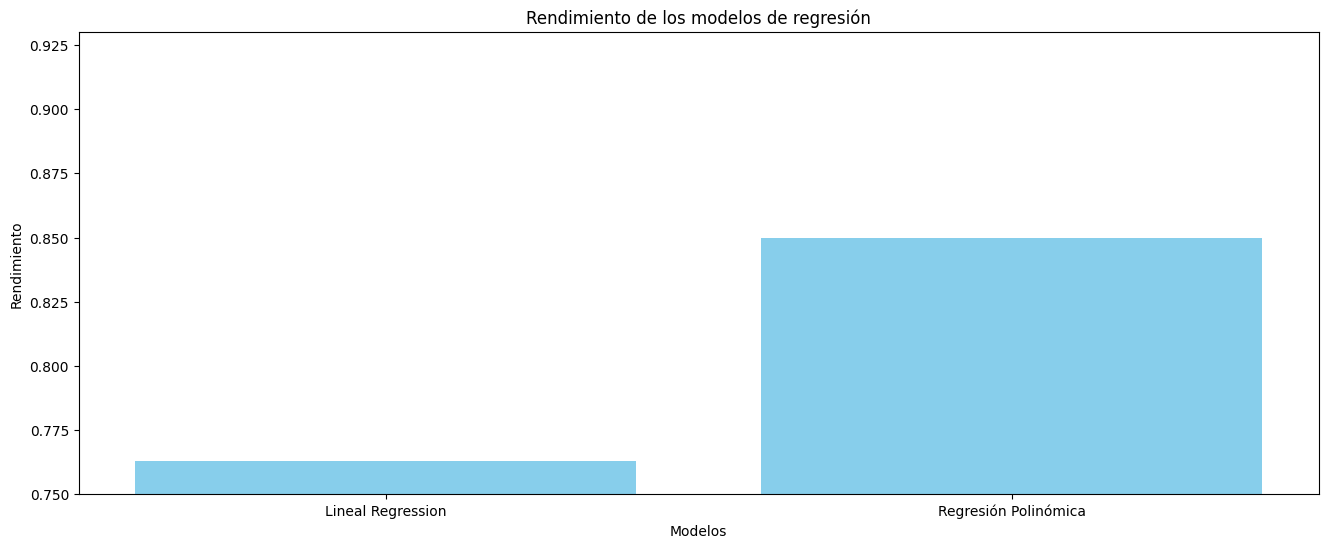

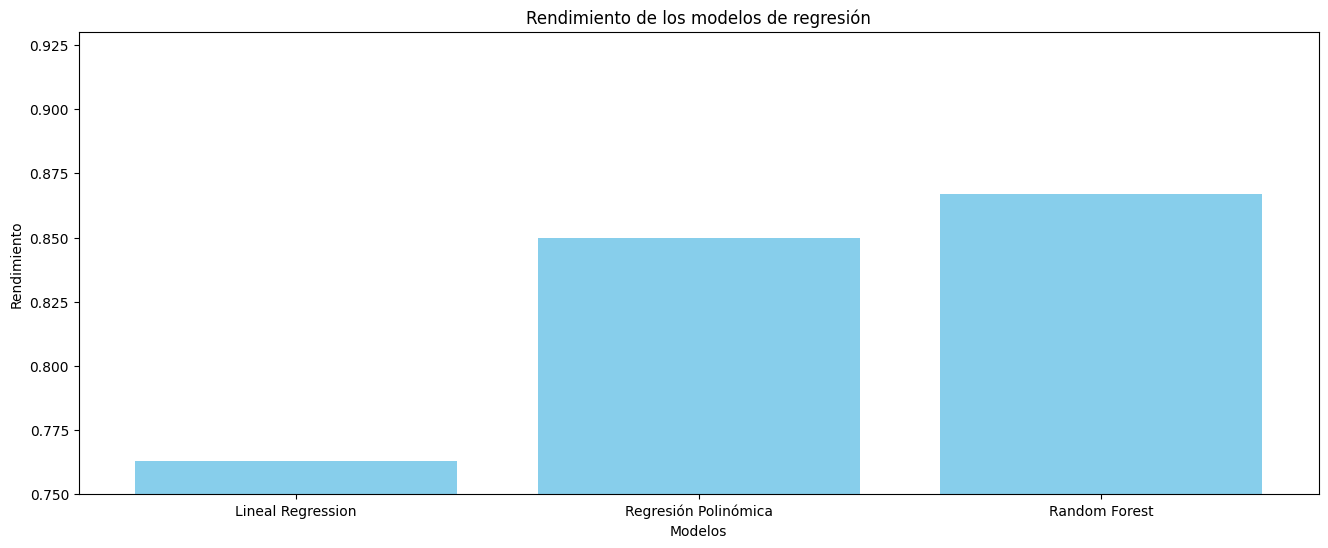

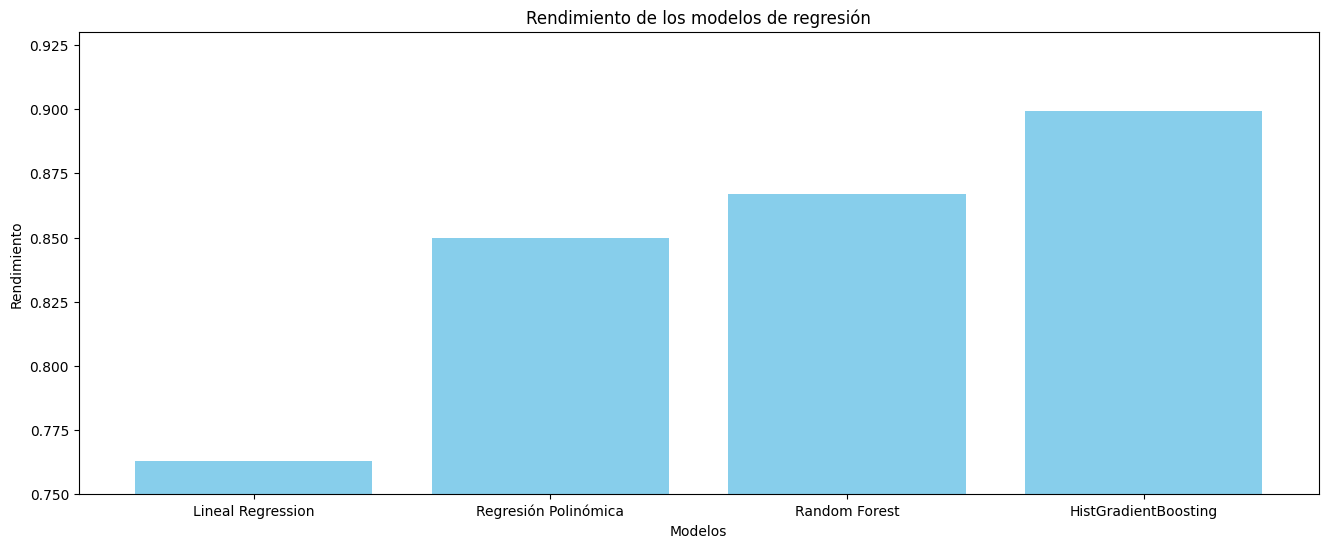

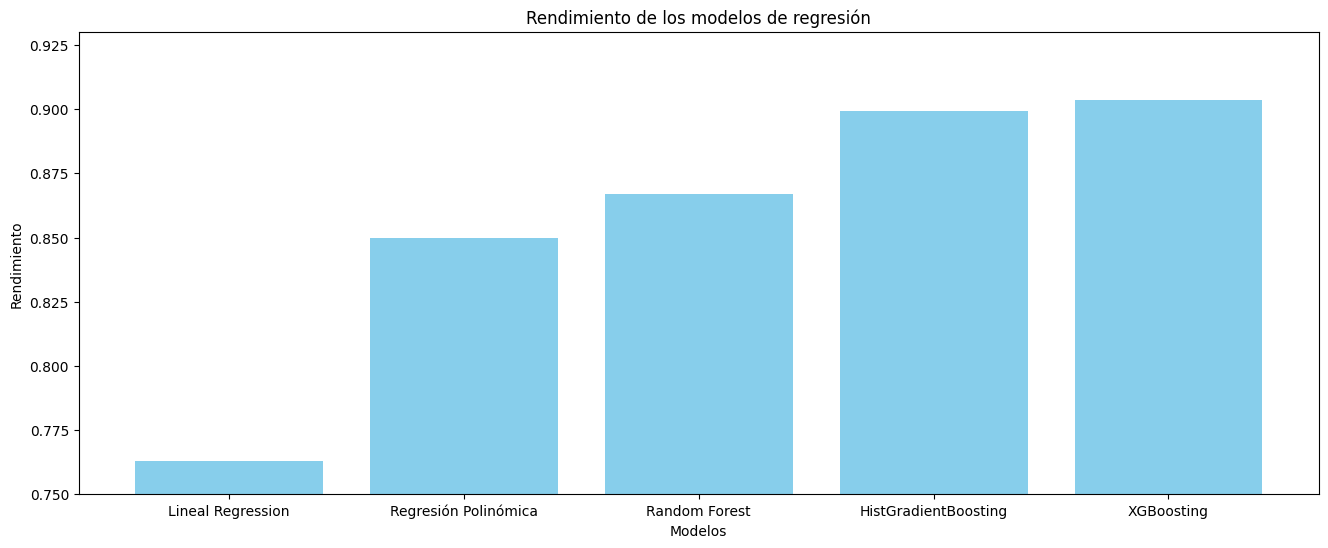

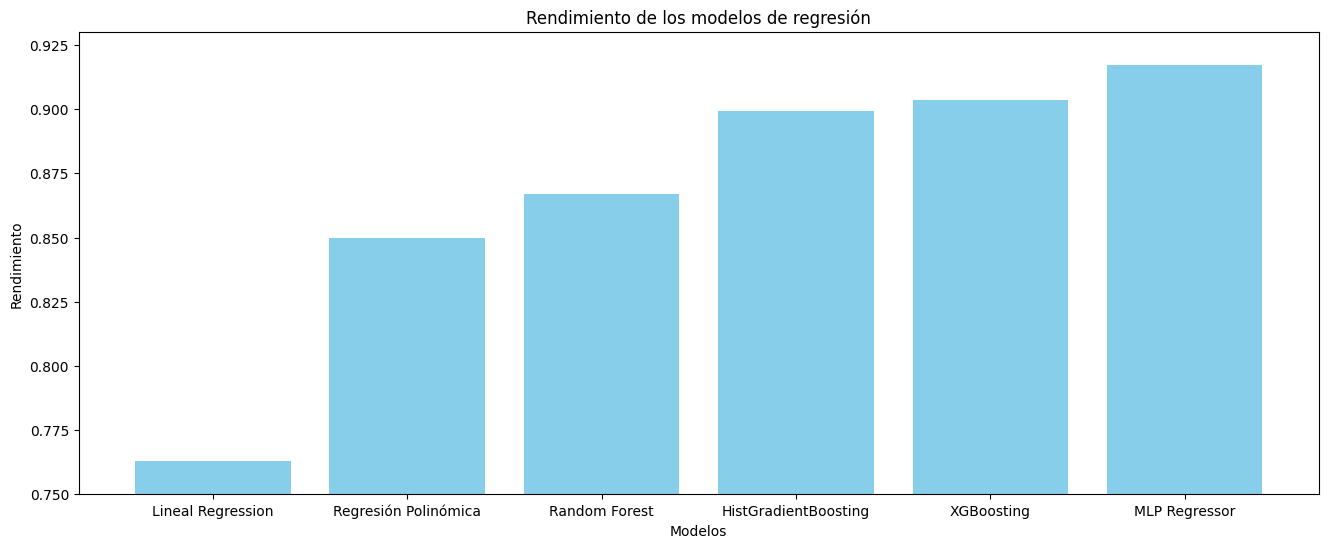

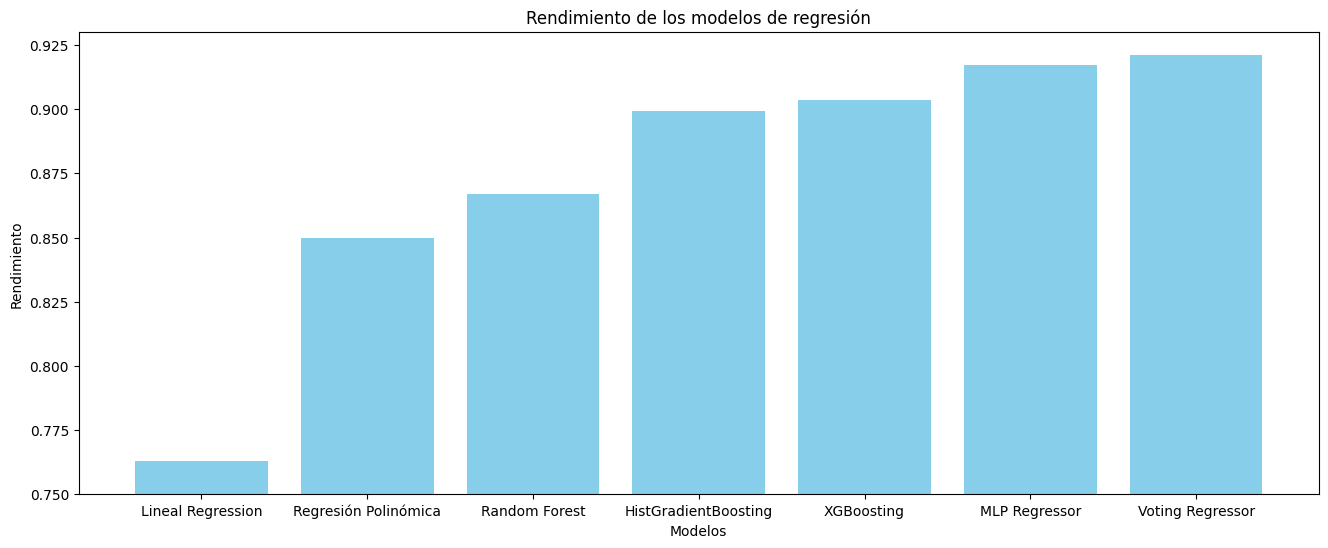

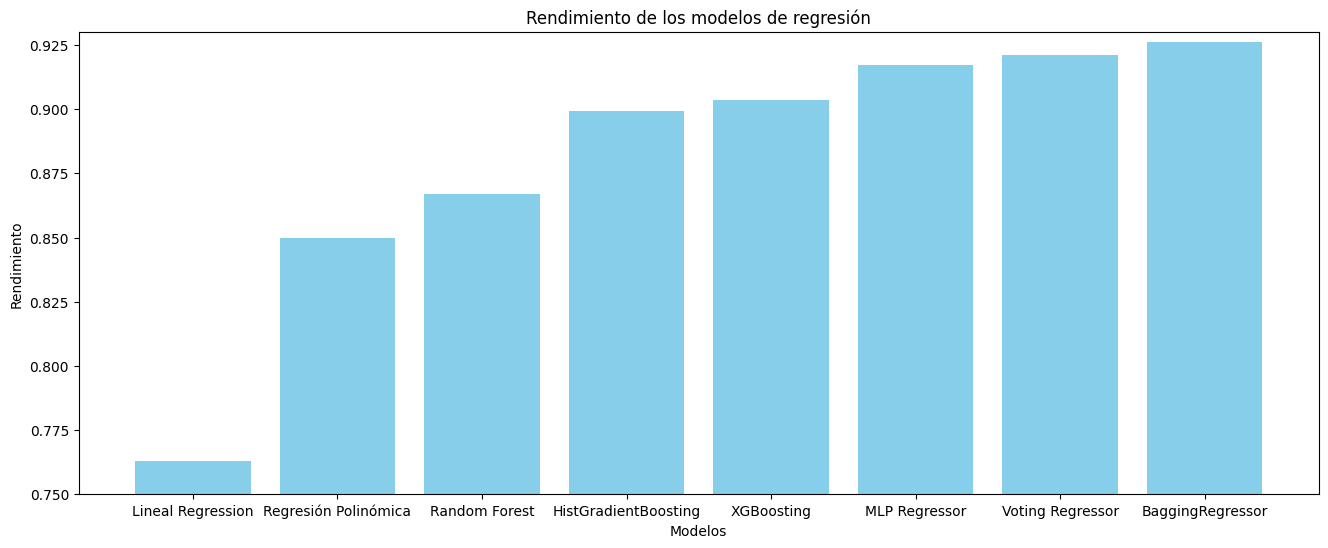

In [13]:
# Lista de resultados de los modelos (rendimientos)
resultados = [0.7629, 0.85, 0.867, 0.8993, 0.9037, 0.9173, 0.9211, 0.9262]  # ejemplo de rendimientos

# Lista de nombres de los modelos
nombres_modelos = ["Lineal Regression", "Regresión Polinómica", "Random Forest", "HistGradientBoosting", "XGBoosting", "MLP Regressor", "Voting Regressor", "BaggingRegressor"]

# Bucle para ir añadiendo modelos progresivamente
for i in range(1, len(nombres_modelos) + 1):
    # Crear la figura y los ejes
    plt.figure(figsize=(16, 6))
    plt.ylim(0.75, 0.93)  # Limitar el rango del eje Y para que no se escale automáticamente

    # Dibujar el histograma con los modelos acumulados
    plt.bar(nombres_modelos[:i], resultados[:i], color='skyblue')

    # Añadir etiquetas y título
    plt.xlabel('Modelos')
    plt.ylabel('Rendimiento')
    plt.title('Rendimiento de los modelos de regresión')

    # Mostrar el gráfico
    plt.show()
